# Feature extraction

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pyopenms import MSExperiment, MzXMLFile, MzMLFile, MzDataFile
from sklearn import preprocessing
from multiprocess import Pool
from numba import jit
import sys
sys.path.append("C:/Users/yxliao/Desktop/Smartgit3/DeepPIC/models")
from DeepPIC import *
from feature_extraction import *

In [2]:
path = "D:/Dpic/data2/leaf_seed/data/10.mzXML"  #LC-MS file
choose_spec0, rt, rt_mean_interval = readms(path)

In [3]:
@jit(nopython=True)
def get_range(choose_spec0, mass_inv = 0.08, rt_inv = 30, min_intensity=50000): 
    scan = len(rt)
    rt_inv = int(rt_inv/rt_mean_interval)
    c = np.ones(len(choose_spec0))
    tol_array = np.hstack(((choose_spec0),(c.reshape(len(c),1))))
    h_rt = []
    h_ms = []
    h_intensity = []
    choose_spec = []
    while True:
        tol_index = np.where(tol_array[:, 3] == 1)
        inded = (tol_array[tol_index[0], 2]).T
        max_ind = np.argmax(inded)
        max_intensity_intensity =inded[max_ind]
        ind = tol_index[0][max_ind]
        h_intensity_rt = tol_array[ind, 0]
        max_intensity_rt_i = np.searchsorted(rt,h_intensity_rt)
        max_int_ms = tol_array[ind, 1]
        # h_intensity_rt=320.123
        # max_intensity_rt_i = np.searchsorted(rt,h_intensity_rt)
        # max_int_ms=733.5922241210938
        # max_intensity_intensity=94767.984375
   
        if max_intensity_intensity < min_intensity:
            break
        else:    
            start = max_intensity_rt_i-rt_inv
            end = max_intensity_rt_i+rt_inv
            if start < 0:
                start = 0
            if end > scan:
                end = scan
            choose_rt = rt[start:end]
            ind_z = []
            for rti in range(len(choose_rt)):
                f = np.searchsorted(tol_array[:, 0],choose_rt[rti])
                h = np.searchsorted(tol_array[:, 0],choose_rt[rti],side='right')
                ind_f = np.searchsorted(tol_array[f:h,1],tol_array[f:h,1][np.abs(tol_array[f:h,1]-max_int_ms) < mass_inv])
                ind_t = ind_f+f
                ind_z.extend(ind_t)   
            index = np.array(ind_z)
            tol_array[index, 3] = 2
            rt1 = tol_array[index, 0]
            ms1 =  tol_array[index, 1]
            int1 = tol_array[index, 2]
            choose_spec_i = np.hstack(((rt1.reshape(len(rt1),1)),(ms1.reshape(len(ms1),1)),(int1.reshape(len(int1),1))))
            h_rt.append(h_intensity_rt)
            choose_spec.append(choose_spec_i)  
            h_intensity.append(max_intensity_intensity)
            h_ms.append(max_int_ms)
                           
    spec_rt = list(zip(choose_spec,h_rt,h_ms,h_intensity))
    #         np.savetxt('%s/%s_%s_%s_%s_%s_%s.txt' % ("D:/Dpic/data2/1167/train2",h_intensity_rt,max_int_ms,max_intensity_intensity,choose_spec_i[0,0],choose_spec_i[-1,0],choose_spec_i.shape[0]),choose_spec_i)
    return spec_rt

In [6]:
choose_spec = get_range(choose_spec0, mass_inv = 1, rt_inv = 15, min_intensity=6000)
p = Pool(5)
array = p.map(get_array,choose_spec)

In [7]:
input_data = Input(shape=(256, 256, 1))
model = get_unet(input_data, n_filters=64, dropout=0.5, batchnorm=True, padding='same')
model.compile(optimizer=Adam(lr = 0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.load_weights('C:/Users/yxliao/Desktop/Smartgit3/release_DeepPIC/best_unet2_zz.h5') #the optimized model

In [8]:
preds = model.predict(scaler(array),batch_size=4,verbose=1)

45/45 [==============================] - 26s 580ms/step


In [9]:
pred_array_int = pred_array(0, preds, array)
pred_array_mz = pred_array(2, preds, array)
pics = pics(array,pred_array_int,pred_array_mz,choose_spec)

In [10]:
pics[0]

array([[   280.36      ,    265.        ,    207.06452942],
       [   280.697     ,    312.        ,    207.07183838],
       [   281.033     ,    489.        ,    207.06443787],
       [   281.369     ,    235.        ,    207.06697083],
       [   281.706     ,    566.        ,    207.06105042],
       [   282.042     ,    772.        ,    207.06324768],
       [   282.38      ,    473.        ,    207.06755066],
       [   282.716     ,    680.        ,    207.06794739],
       [   283.052     ,    652.        ,    207.06213379],
       [   283.389     ,    520.        ,    207.06248474],
       [   283.725     ,    460.        ,    207.06382751],
       [   284.061     ,    332.        ,    207.06863403],
       [   284.398     ,    309.        ,    207.07067871],
       [   284.734     ,    287.        ,    207.06188965],
       [   285.071     ,    688.        ,    207.06385803],
       [   285.408     ,   1965.        ,    207.06373596],
       [   285.744     ,   8606.        

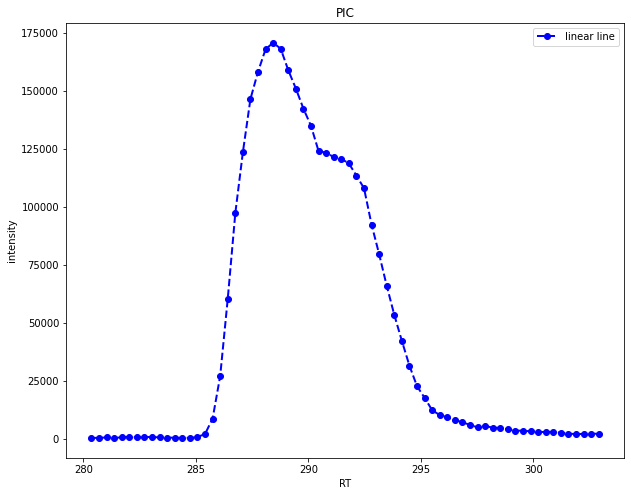

In [11]:
plt.figure( figsize=(10,8))
plt.plot(pics[0][:, 0], pics[0][:, 1], marker='o', color='b', linewidth=2.0, linestyle='--', label='linear line')
plt.legend(loc='upper right')
plt.xlabel('RT')
plt.ylabel('intensity')
plt.title("PIC")
plt.show()